In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os
from sklearn.metrics import f1_score

In [3]:
data_dir = "/content/drive/MyDrive/car_data"
test_dir = data_dir + '/test'

In [4]:
test_transforms = transforms.Compose([transforms.Resize((200,200)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
# print("Length of testing dataset is ---{} ".format(len(testloader.dataset)))

# Loading model

In [5]:
model_resnet152 = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
# model_resnet101

In [6]:
num_ftrs = model_resnet152.fc.in_features
model_resnet152.fc = nn.Linear(num_ftrs, 199)

In [7]:
def load_checkpoint(model, filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [8]:
# Loading model
model_resnet152 = load_checkpoint(model_resnet152, "/content/drive/MyDrive/resnet152_weights_saved_new.pth")
# Checking model i.e. should have 199 output units in the classifier
# print(model)

In [9]:
classes = test_data.classes
# classes[:10]

In [10]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((200,200)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [11]:
model_path = "/content/drive/MyDrive/resnet152_weights_saved_new.pth"

## Testing with unseen examples

In [12]:
path = "/content/drive/MyDrive/test_progi/Elantra 2017"   
dirs_images = os.listdir(path)
dirs_images

['PastedGraphic-12.jpg',
 'PastedGraphic-13.jpg',
 'PastedGraphic-22.jpg',
 'PastedGraphic-21.jpg']

In [13]:
path_im = []
for i in range(len(dirs_images)):
  path_im.append(os.path.join(path, dirs_images[i])) 
path_im

['/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-12.jpg',
 '/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-13.jpg',
 '/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-22.jpg',
 '/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-21.jpg']

In [14]:
from google.colab.patches import cv2_imshow

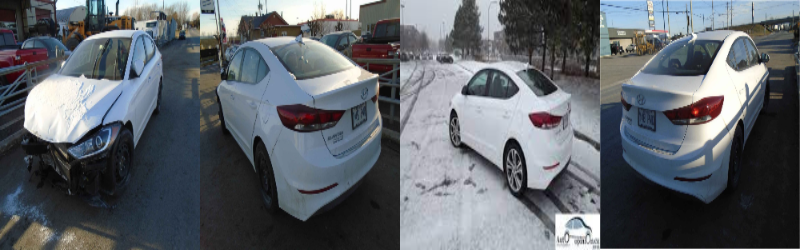

In [15]:
import cv2
import numpy as np
  
# for i in range(len(path)):
# Read First Image
img1 = cv2.imread(path_im[0])
img1 = cv2.resize(img1, (250, 200)) 
# print(img1.shape)
# Read Second Image
img2 = cv2.imread(path_im[1])
img2 = cv2.resize(img2, (250, 200)) 
# print(img2.shape)
# Read Third Image
img3 = cv2.imread(path_im[2])
img3 = cv2.resize(img3, (250, 200)) 
# print(img3.shape)
# Read Fouth Image
img4 = cv2.imread(path_im[3])
img4 = cv2.resize(img4, (250, 200)) 
# print(img4.shape)
# concatanate image Horizontally
Hori = np.concatenate((img1, img2, img3, img4), axis=1)
  
ims = cv2.resize(Hori, (800, 250))

cv2_imshow(ims)

In [25]:
predicted_labels_list = []

def predict(path_to_images, model):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model_resnet152, model_path).cpu()
    # Pre-processing image
    for image_path in path_to_images:
      # print(image_path)

      img = process_image(image_path)
      # Converting to torch tensor from Numpy array
      img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
      # Adding dimension to image to comply with (B x C x W x H) input of model
      img_add_dim = img_tensor.unsqueeze_(0)
      print(img_add_dim.shape)

      # Setting model to evaluation mode and turning off gradients
      loaded_model.eval()
      with torch.no_grad():
          # Running image through network
          output = loaded_model.forward(img_add_dim)
          
      #conf, predicted = torch.max(output.data, 1)   
      # probs_top = output.topk(topk)[0]
      a = torch.argmax(output, dim=1)[0]
      # print(a)
      
      predicted_labels_list.append(classes[int(a)])
    
    # print(predicted_labels_list)
    final_predicted_label = max(predicted_labels_list, key = predicted_labels_list.count)
    # print(prediction)
    # print(final_predicted_label)

    return predicted_labels_list, final_predicted_label

In [26]:
path_im = path_im[:3]
path_im

['/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-12.jpg',
 '/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-13.jpg',
 '/content/drive/MyDrive/test_progi/Elantra 2017/PastedGraphic-22.jpg']

#<font color = blue> Prediction of the class label

In [27]:
classes_labels, predicted_label = predict(path_im, model_resnet152)

torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


In [28]:
print(classes_labels)

['Daewoo Nubira Wagon 2002', 'Hyundai Elantra Sedan 2007', 'Hyundai Elantra Sedan 2007']


In [29]:
print(predicted_label)

Hyundai Elantra Sedan 2007


(744, 992, 3)


Text(0.5, 1.0, 'Honda Civic 2016')

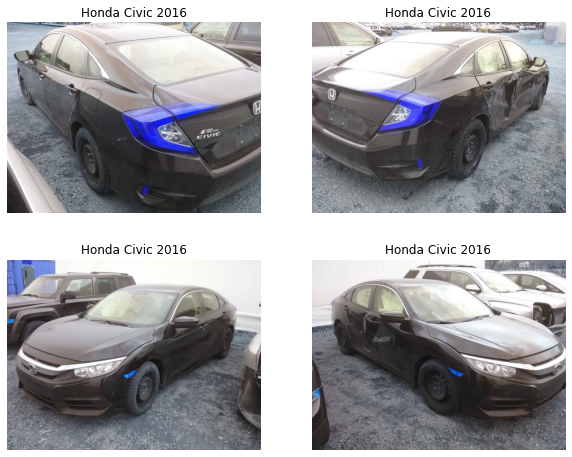

In [ ]:
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 8))

rows = 2
columns = 2

Image1 = cv2.imread(path_im[0])
print(Image1.shape)
  
# Read Second Image
Image2 = cv2.imread(path_im[1])

# Read Third Image
Image3 = cv2.imread(path_im[2])

# Read Fouth Image
Image4 = cv2.imread(path_im[3])

fig.add_subplot(rows, columns, 1)
# showing image

plt.imshow(Image1)
plt.axis('off')
plt.title(classes_labels[0])
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title(classes_labels[1])
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title(classes_labels[2])
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title(classes_labels[3])



In [ ]:
print(predicted_label)

Honda Civic 2016
